# RSSI만을 이용한 모델에서의 성능 평가

### Data

* **Distance**
    * Distance between the Tag and the Attacker
    * 0m, 1m, 2m


* **Number of Data**
    * Number of Data for Spoofing Attack Detection Prediction
    * 50개, 100개, 500개
    
    
* **Packet Speed**
    * RSSI 값은 Packet Speed에 영향을 받지 않으므로 본 실험에선 제외
    * Speed of the Beacon Data the Anchor Point receives
    * Average Time Interval of **Fast** (0.03ms), **Normal** (0.13ms), **Slow** (0.35ms)
  
  
* 총 27가지 상황의 데이터 수집
    * 각 상황에 따라 100개의 파일로 수집
    * 결론적으로 2700개의 데이터 파일 수집

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Kalman Filter
class KalmanFilter():
    def __init__(self, processNoise, measurementNoise):
        super(KalmanFilter, self).__init__()
        self.processNoise = processNoise # Process noise = 0.0005
        self.measurementNoise = measurementNoise # Measurement noise = 20
        self.estimatedRSSI = 0.0 # calculated rssi
        self.errorCovarianceRSSI = 0.0 # calculated covariance
        self.isInitialized = False # initialization flag

    def applyFilter(self, rssi):
        priorRSSI = 0.0
        kalmanGain = 0.0
        priorErrorCovarianceRSSI = 0.0

        if not self.isInitialized:
            priorRSSI = rssi
            priorErrorCovarianceRSSI = 1
            self.isInitialized = True
        else:
            priorRSSI = self.estimatedRSSI
            priorErrorCovarianceRSSI = self.errorCovarianceRSSI + self.processNoise

        kalmanGain = priorErrorCovarianceRSSI / (priorErrorCovarianceRSSI + self.measurementNoise)
        self.estimatedRSSI = priorRSSI + (kalmanGain * (rssi - priorRSSI))
        self.errorCovarianceRSSI = (1 - kalmanGain) * priorErrorCovarianceRSSI

        return self.estimatedRSSI

In [3]:
# Check incoming RSSI value in IQR range with Kalman Filter
class RSSI():
    def __init__(self):
        self.rssi_arr = []
        self.kf = KalmanFilter(processNoise=1, measurementNoise=1)
        
    # Resize RSSI array (Prevent overflow)
    def full_arr(self):
        del self.rssi_arr[:len(self.rssi_arr) - 100]

    # Check incoming RSSI value in IQR range
    def check_val(self, min, max, val):
        if min < val < max:
            return 0
        else:
            if val < min:
                return min - val
            else:
                return val - max    

    def add_rssi(self, rssi):
        if len(self.rssi_arr) > 10000:
            self.full_arr()

        self.rssi_arr.append(self.kf.applyFilter(rssi))

    # Check Interqurtile range (IQR) & RSSI Boundary
    def check_rssi(self, curr, prev):
        Q1 = np.percentile(self.rssi_arr, 25)
        Q3 = np.percentile(self.rssi_arr, 75)
        IQR = (Q3 - Q1) * 1.5

        min = Q1 - IQR
        max = Q3 + IQR

        curr_val = self.check_val(min, max, self.kf.applyFilter(curr))
        prev_val = self.check_val(min, max, self.kf.applyFilter(prev))

        if curr_val == 0 and prev_val == 0:
            # Not Spoofing Attack
            return False
        else:
            # Spoofing Attack
            return True
        
    # Check Interqurtile range (IQR) & RSSI Boundary
    def check_iqr (self):
        Q1 = np.percentile(self.rssi_arr, 25)
        Q3 = np.percentile(self.rssi_arr, 75)
        IQR = (Q3 - Q1) * 1.5

        min = Q1 - IQR
        max = Q3 + IQR

        print("IQR :", IQR)
        print("Min RSSI :", min)
        print("Max RSSI :", max)

In [4]:
# Check Spoofing Attack according to Data files
res = []
    
for i in range(1, 2701):
    df = pd.read_csv('./data/data' + str(i) + '.csv')

    df_rssi = df['rssi']

    RSSI_d = RSSI()

    for j in range(len(df_rssi)):
        if j != len(df_rssi) - 1:
            RSSI_d.add_rssi(df_rssi[j])
        else:
            spoof_check = RSSI_d.check_rssi(df_rssi[j], df_rssi[j-1])

    if spoof_check:
        res.append(True)
    else:
        res.append(False)

In [5]:
# Check Entire Result
print("Number of entire files :",len(res))
print("Entire Accuracy of detection :", (res.count(True) / len(res)) * 100, "%")

Number of entire files : 2700
Entire Accuracy of detection : 67.5925925925926 %


In [6]:
# Filter Result Data
case_50 = res[0:300] + res[900:1200] + res[1800:2100]
case_100 = res[300:600] + res[1200:1500] + res[2100:2400]
case_500 = res[600:900] + res[1500:1800] + res[2400:2700]

case_0 = res[0:100] + res[300:400] + res[600:700] + res[900:1000] + res[1200:1300] + res[1500:1600] + res[1800:1900] + res[2100:2200] + res[2400:2500]
case_1 = res[100:200] + res[400:500] + res[700:800] + res[1000:1100] + res[1300:1400] + res[1600:1700] + res[1900:2000] + res[2200:2300] + res[2500:2600]
case_2 = res[200:300] + res[500:600] + res[800:900] + res[1100:1200] + res[1400:1500] + res[1700:1800] + res[2000:2100] + res[2300:2400] + res[2600:2700]

# Number of Data for Spoofing Attack Detection Prediction
acc_50 = case_50.count(True)
acc_100 = case_100.count(True)
acc_500 = case_500.count(True)

# Distance between Tag and Attacker
acc_0 = case_0.count(True)
acc_1 = case_1.count(True)
acc_2 = case_2.count(True)

In [7]:
# Check Filtered Result
print("< 예측 사용 데이터 갯수 >")
print("- 50개 :", acc_50 / len(case_50) * 100, "%")
print("- 100개 :", acc_100 / len(case_100) * 100, "%")
print("- 500개 :", acc_500 / len(case_500) * 100, "%")
print("\n< 정상 Tag와 공격자 사이의 거리 >")
print("- 0m :", acc_0 / len(case_0) * 100, "%")
print("- 1m :", acc_1 / len(case_1) * 100, "%")
print("- 2m :", acc_2 / len(case_2) * 100, "%")

< 예측 사용 데이터 갯수 >
- 50개 : 67.88888888888889 %
- 100개 : 67.44444444444444 %
- 500개 : 67.44444444444444 %

< 정상 Tag와 공격자 사이의 거리 >
- 0m : 3.4444444444444446 %
- 1m : 99.33333333333333 %
- 2m : 100.0 %


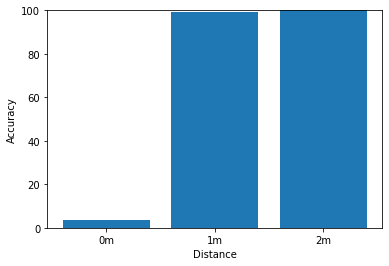

In [8]:
x = np.arange(3)
testCase_num = ['0m', '1m', '2m']
values = [(acc_0 / len(case_0)) * 100, (acc_1 / len(case_1)) * 100, (acc_2 / len(case_2)) * 100 ]

plt.bar(x, values)
plt.xticks(x, testCase_num)
plt.ylim([0, 100])
plt.xlabel('Distance')
plt.ylabel('Accuracy')

plt.show()

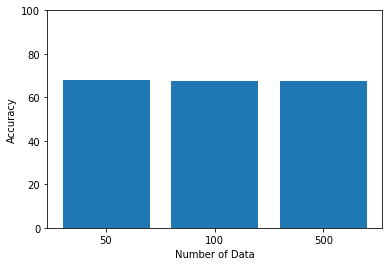

In [9]:
x = np.arange(3)
testCase_num = ['50', '100', '500']
values = [(acc_50 / len(case_50)) * 100, (acc_100 / len(case_100)) * 100, (acc_500 / len(case_500)) * 100 ]

plt.bar(x, values)
plt.xticks(x, testCase_num)
plt.ylim([0, 100])
plt.xlabel('Number of Data')
plt.ylabel('Accuracy')

plt.show()